<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/bathymetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install essential libraries
!pip install plotly geopandas rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 95.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

# For XYZ data (tabular format)
bathy_df = pd.read_csv('/content/Apr19_bathy_NAVD88.xyz',
                      delim_whitespace=True,
                      names=['Longitude', 'Latitude', 'Depth'])

# For ASC/Esri ASCII (gridded format)
with open('Apr19_bathy_NAVD88.asc') as f:
    ncols = int(f.readline().split()[1])
    nrows = int(f.readline().split()[1])
    xll = float(f.readline().split()[1])  # xllcorner/center
    yll = float(f.readline().split()[1])  # yllcorner/center
    cellsize = float(f.readline().split()[1])
    nodata = float(f.readline().split()[1])

    data = np.loadtxt(f, dtype=np.float32)

depth_grid = np.flipud(data)  # ASC files are top-to-bottom

<ipython-input-3-c25d3307aaee>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bathy_df = pd.read_csv('/content/Apr19_bathy_NAVD88.xyz',


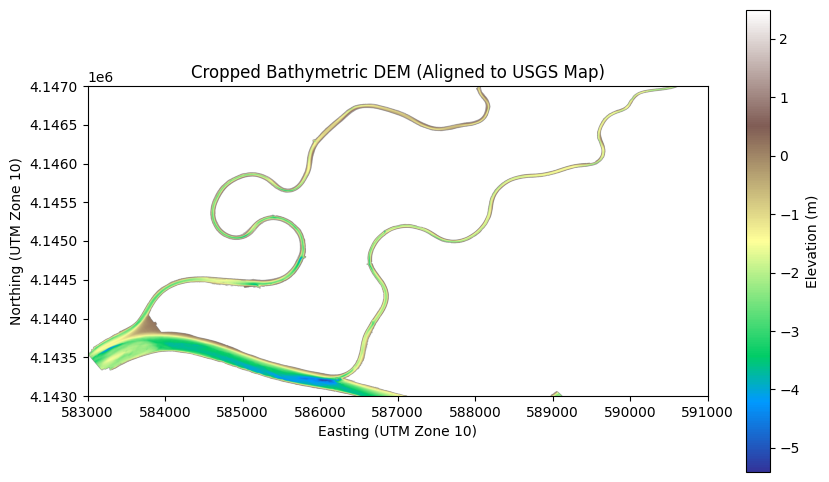

In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

# Load the ASC file
with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])  # Bottom-right corner

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Find index range for cropping
    x_range = (583000, 591000)
    y_range = (4143000, 4147000)

    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    # Crop array
    cropped_array = array[y_indices.min():y_indices.max(), x_indices.min():x_indices.max()]

plt.figure(figsize=(10, 6))
plt.imshow(cropped_array, cmap="terrain", interpolation="bilinear", origin="lower",
           extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
plt.colorbar(label="Elevation (m)")
plt.title("Cropped Bathymetric DEM (Aligned to USGS Map)")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.show()


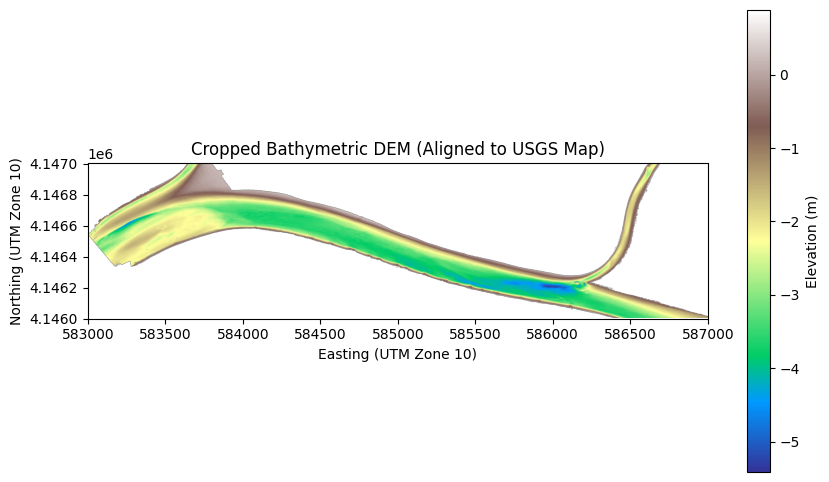

In [29]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

# Load the ASC file
with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])  # Bottom-right corner

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Find index range for cropping
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    # Crop array
    cropped_array = array[y_indices.min():y_indices.max(), x_indices.min():x_indices.max()]

plt.figure(figsize=(10, 6))
plt.imshow(cropped_array, cmap="terrain", interpolation="bilinear", origin="lower",
           extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
plt.colorbar(label="Elevation (m)")
plt.title("Cropped Bathymetric DEM (Aligned to USGS Map)")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.show()

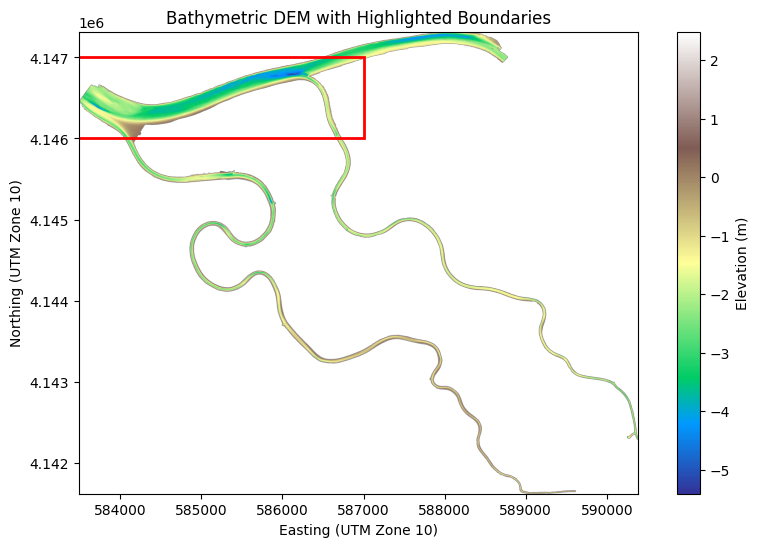

In [31]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

# Load the ASC file
with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Find index range for cropping
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    # Crop array
    cropped_array = array[y_indices.min():y_indices.max(), x_indices.min():x_indices.max()]

plt.figure(figsize=(10, 6))
plt.imshow(array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[x_min, x_max, y_min, y_max])  # Ensure correct extent
plt.colorbar(label="Elevation (m)")

# Highlight the specified range with a rectangle
rect_x = x_range[0]
rect_y = y_range[0]
rect_width = x_range[1] - x_range[0]
rect_height = y_range[1] - y_range[0]

plt.gca().add_patch(Rectangle((rect_x, rect_y), rect_width, rect_height,
                              linewidth=2, edgecolor='red', facecolor='none'))

plt.title("Bathymetric DEM with Highlighted Boundaries")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.show()

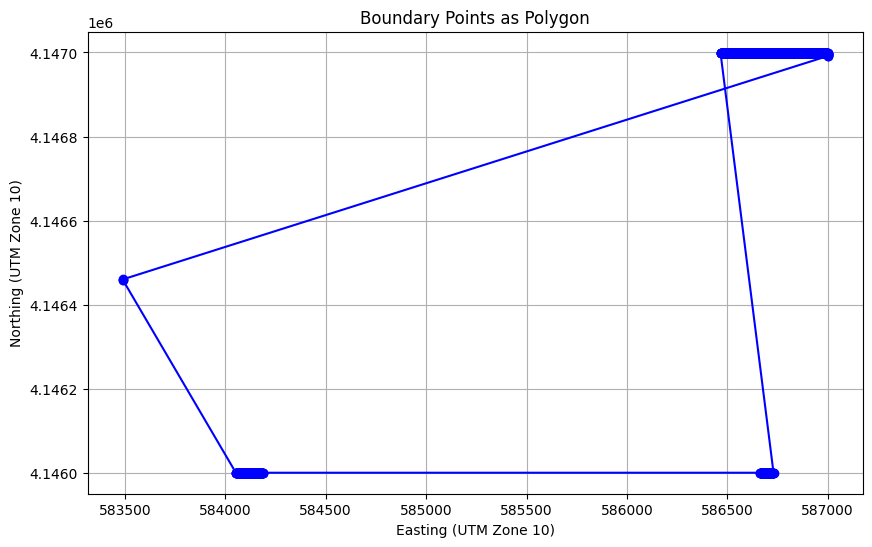

In [32]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import csv

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

# Load the ASC file
with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Define cropping range
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    # Find index range for cropping
    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    # Crop array
    cropped_array = array[y_indices.min():y_indices.max() + 1, x_indices.min():x_indices.max() + 1]

# Extract boundary points
boundary_points = []
for i in range(cropped_array.shape[0]):
    for j in range(cropped_array.shape[1]):
        if i == 0 or i == cropped_array.shape[0] - 1 or j == 0 or j == cropped_array.shape[1] - 1:
            if not np.isnan(cropped_array[i, j]):
                x_coord = x_coords[x_indices.min() + j]
                y_coord = y_coords[y_indices.min() + i]
                depth = cropped_array[i, j]
                boundary_points.append((x_coord, y_coord, depth))

# Save boundary points to a CSV file
csv_file = "boundary_points.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["X Coordinate", "Y Coordinate", "Depth"])
    writer.writerows(boundary_points)

# Plot the boundary points as a polygon
x_polygon = [point[0] for point in boundary_points]
y_polygon = [point[1] for point in boundary_points]

plt.figure(figsize=(10, 6))
plt.plot(x_polygon + [x_polygon[0]], y_polygon + [y_polygon[0]], marker='o', linestyle='-', color='blue')
plt.title("Boundary Points as Polygon")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.grid(True)
plt.show()


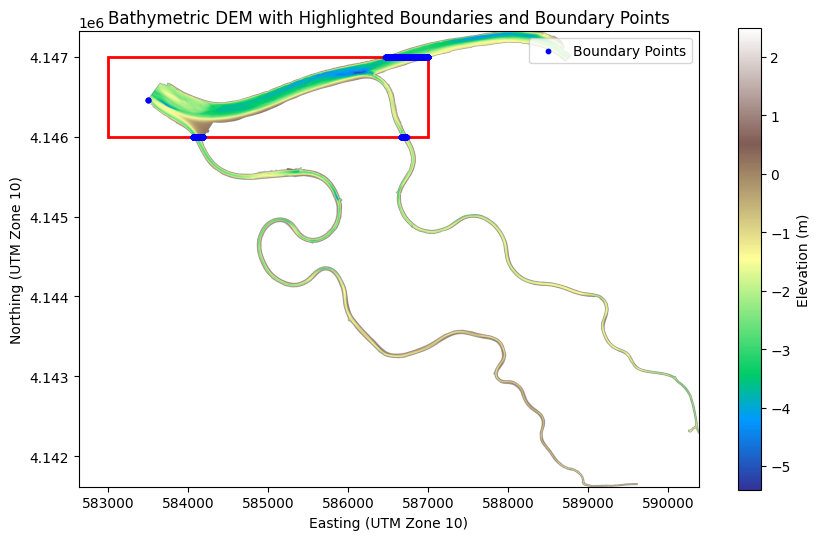

In [33]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import csv

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

# Load the ASC file
with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Define cropping range
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    # Find index range for cropping
    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    # Crop array
    cropped_array = array[y_indices.min():y_indices.max() + 1, x_indices.min():x_indices.max() + 1]

# Extract boundary points of the cropped region
boundary_points = []
for i in range(cropped_array.shape[0]):
    for j in range(cropped_array.shape[1]):
        if i == 0 or i == cropped_array.shape[0] - 1 or j == 0 or j == cropped_array.shape[1] - 1:
            if not np.isnan(cropped_array[i, j]):
                x_coord = x_coords[x_indices.min() + j]
                y_coord = y_coords[y_indices.min() + i]
                depth = cropped_array[i, j]
                boundary_points.append((x_coord, y_coord, depth))

# Save boundary points to a CSV file
csv_file = "boundary_points.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["X Coordinate", "Y Coordinate", "Depth"])
    writer.writerows(boundary_points)

# Plot the main raster with boundary points overlayed
plt.figure(figsize=(10, 6))
plt.imshow(array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label="Elevation (m)")

# Highlight the specified range with a rectangle
rect_x = x_range[0]
rect_y = y_range[0]
rect_width = x_range[1] - x_range[0]
rect_height = y_range[1] - y_range[0]

plt.gca().add_patch(plt.Rectangle((rect_x, rect_y), rect_width, rect_height,
                                  linewidth=2, edgecolor='red', facecolor='none'))

# Overlay boundary points on the raster plot
boundary_xs = [point[0] for point in boundary_points]
boundary_ys = [point[1] for point in boundary_points]
plt.scatter(boundary_xs, boundary_ys, color='blue', s=10, label="Boundary Points")

plt.title("Bathymetric DEM with Highlighted Boundaries and Boundary Points")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


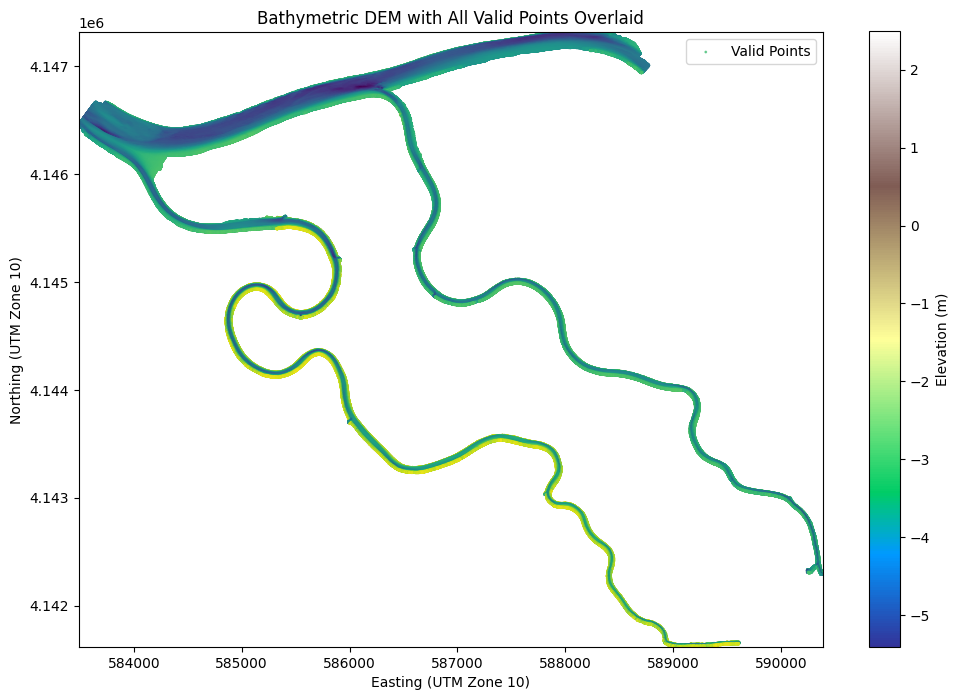

In [34]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

# Load the ASC file
with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

# Extract all valid points (non-NaN values) with their coordinates and depth
data_points = []
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        if not np.isnan(array[i, j]):
            x_coord = x_coords[j]
            y_coord = y_coords[i]
            depth = array[i, j]
            data_points.append((x_coord, y_coord, depth))

# Split data points into X, Y, and Depth for plotting
x_data = [point[0] for point in data_points]
y_data = [point[1] for point in data_points]
depth_data = [point[2] for point in data_points]

# Plot the main raster with all valid points overlaid
plt.figure(figsize=(12, 8))
plt.imshow(array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label="Elevation (m)")

# Overlay all valid points as a scatter plot
plt.scatter(x_data, y_data, c=depth_data, cmap="viridis", s=1, label="Valid Points", alpha=0.7)

plt.title("Bathymetric DEM with All Valid Points Overlaid")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.legend()
plt.show()


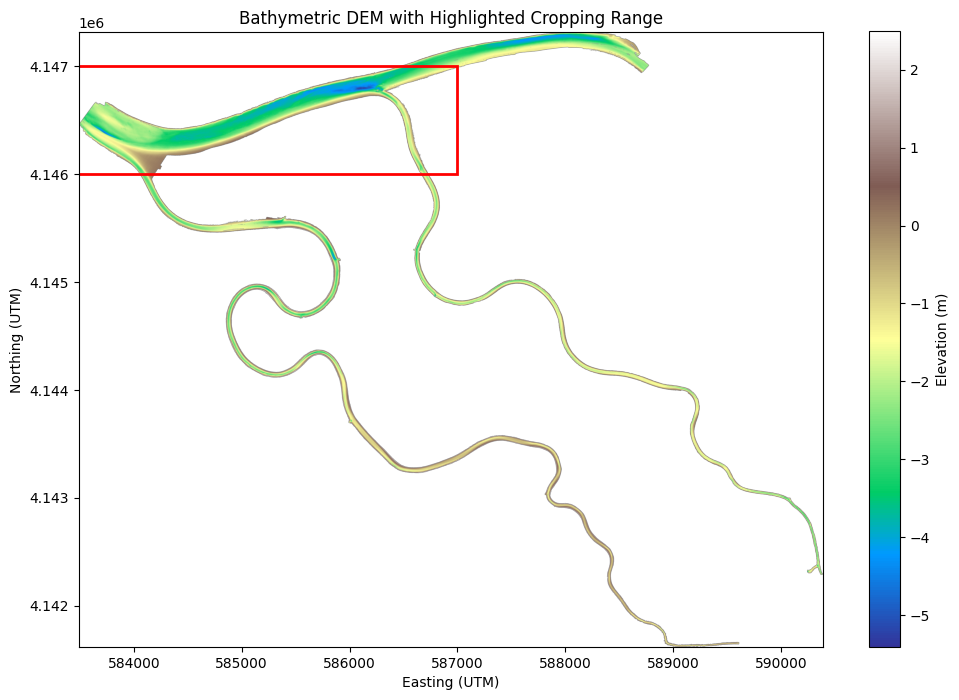

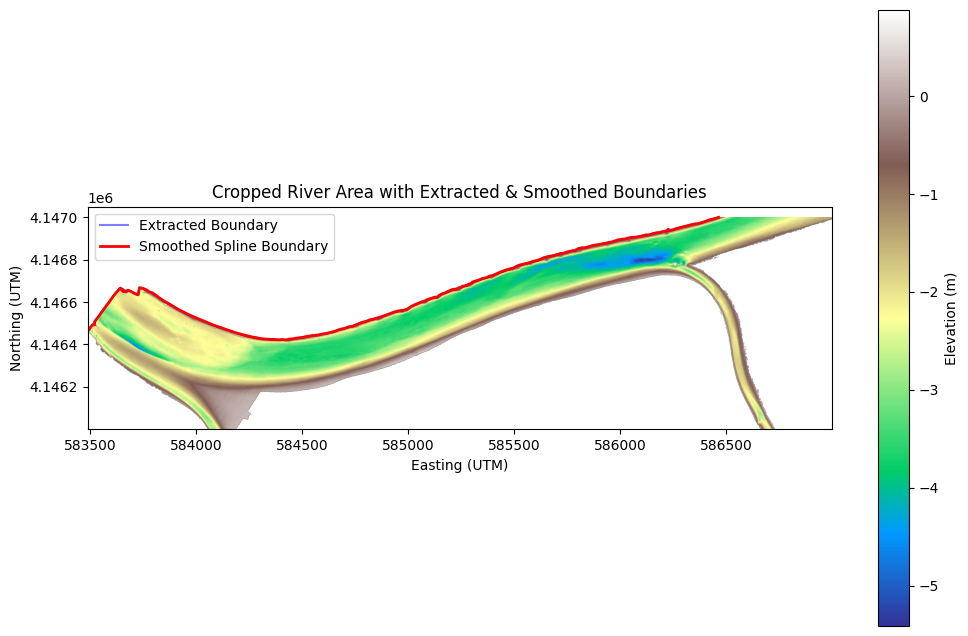

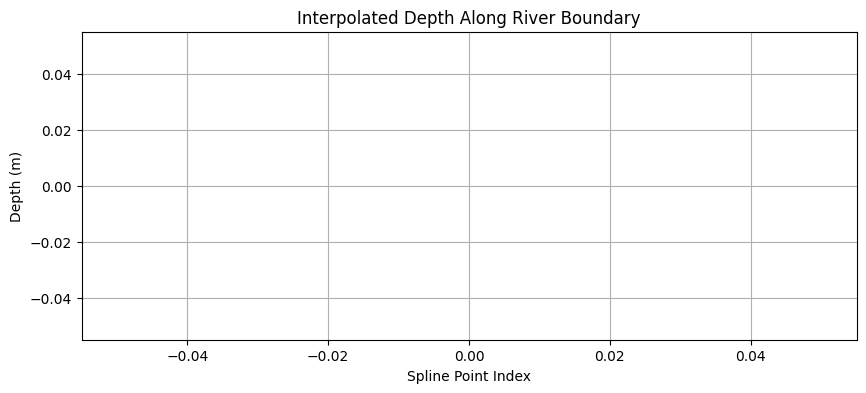

In [35]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.measure import find_contours
from scipy.interpolate import splprep, splev, RegularGridInterpolator

# --- Step 1: Load and Crop the Bathymetric Data ---
asc_file = "/content/Apr19_bathy_NAVD88.asc"

with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate coordinate arrays (UTM)
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Define the cropping bounds
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    # Determine indices that fall within the specified bounds
    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    # Crop the array and corresponding coordinate arrays
    x_start, x_end = x_indices.min(), x_indices.max() + 1
    y_start, y_end = y_indices.min(), y_indices.max() + 1
    cropped_array = array[y_start:y_end, x_start:x_end]
    cropped_x = x_coords[x_start:x_end]
    cropped_y = y_coords[y_start:y_end]

# --- Step 2: Identify the River via a Binary Mask & Extract Its Boundary ---
# Assume valid depth data (non-NaN) corresponds to the river.
river_mask = ~np.isnan(cropped_array)

# Use skimage to extract contours at the 0.5 level (binary threshold)
contours = find_contours(river_mask.astype(float), 0.5)
if not contours:
    raise ValueError("No river contours found!")
# Select the longest contour (assumed to be the outer boundary)
longest_contour = max(contours, key=lambda c: c.shape[0])

# The contour is given in (row, col) coordinates relative to cropped_array.
# Convert these to world (UTM) coordinates using the offset from cropping.
contour_rows = longest_contour[:, 0]
contour_cols = longest_contour[:, 1]
world_coords = [transform * (col + x_start, row + y_start)
                for row, col in zip(contour_rows, contour_cols)]
boundary_x = np.array([pt[0] for pt in world_coords])
boundary_y = np.array([pt[1] for pt in world_coords])

# --- Step 3: Fit a Smoothing Spline to Create a Continuous Boundary ---
# The spline provides a smooth, continuous representation.
tck, u = splprep([boundary_x, boundary_y], s=5)
u_fine = np.linspace(0, 1, 200)  # 200 points along the boundary
spline_x, spline_y = splev(u_fine, tck)

# --- Step 4: Interpolate Depth Data Along the Continuous Boundary ---
# Prepare an interpolator on the cropped bathymetry.
# RegularGridInterpolator requires ascending grid values.
cropped_y_sorted = cropped_y[::-1]           # Reverse rows to get ascending y
cropped_array_sorted = cropped_array[::-1, :]  # Flip rows accordingly
interp_func = RegularGridInterpolator(
    (cropped_y_sorted, cropped_x),
    cropped_array_sorted,
    bounds_error=False,
    fill_value=np.nan
)

# Interpolator expects (y, x) pairs.
spline_points = np.column_stack((spline_y, spline_x))
depth_along_boundary = interp_func(spline_points)

# --- Step 5: Visualize the Results ---

# Plot the full DEM with the cropping rectangle
plt.figure(figsize=(12, 8))
plt.imshow(array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label="Elevation (m)")
plt.gca().add_patch(Rectangle((x_range[0], y_range[0]),
                              x_range[1] - x_range[0],
                              y_range[1] - y_range[0],
                              linewidth=2, edgecolor='red', facecolor='none'))
plt.title("Bathymetric DEM with Highlighted Cropping Range")
plt.xlabel("Easting (UTM)")
plt.ylabel("Northing (UTM)")
plt.show()

# Plot the cropped area with extracted and smoothed boundaries
plt.figure(figsize=(12, 8))
plt.imshow(cropped_array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[cropped_x[0], cropped_x[-1], cropped_y[-1], cropped_y[0]])
plt.colorbar(label="Elevation (m)")
plt.plot(boundary_x, boundary_y, 'b-', label="Extracted Boundary", alpha=0.5)
plt.plot(spline_x, spline_y, 'r-', label="Smoothed Spline Boundary", linewidth=2)
plt.title("Cropped River Area with Extracted & Smoothed Boundaries")
plt.xlabel("Easting (UTM)")
plt.ylabel("Northing (UTM)")
plt.legend()
plt.show()

# Plot the depth along the continuous boundary
plt.figure(figsize=(10, 4))
plt.plot(depth_along_boundary, 'k-')
plt.title("Interpolated Depth Along River Boundary")
plt.xlabel("Spline Point Index")
plt.ylabel("Depth (m)")
plt.grid(True)
plt.show()

# --- Final Notes ---
# (spline_x, spline_y) along with depth_along_boundary now provide a continuous
# representation of the river boundary. In your simulation, you can use these data
# to impose continuous Neumann boundary conditions by specifying the normal derivative
# (computed from the smooth spline) along the river's edge.


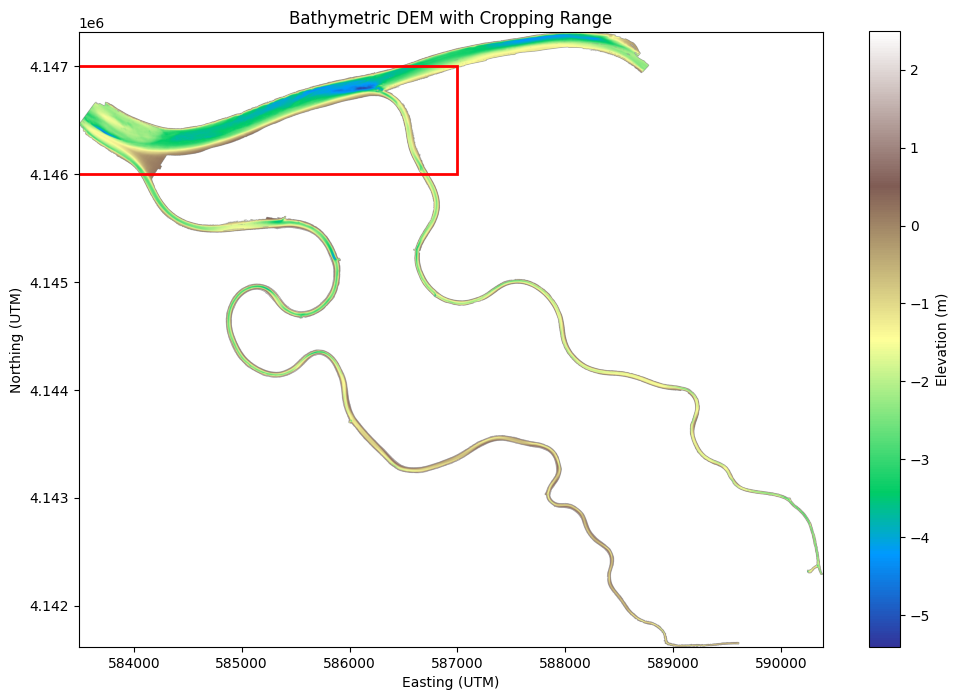

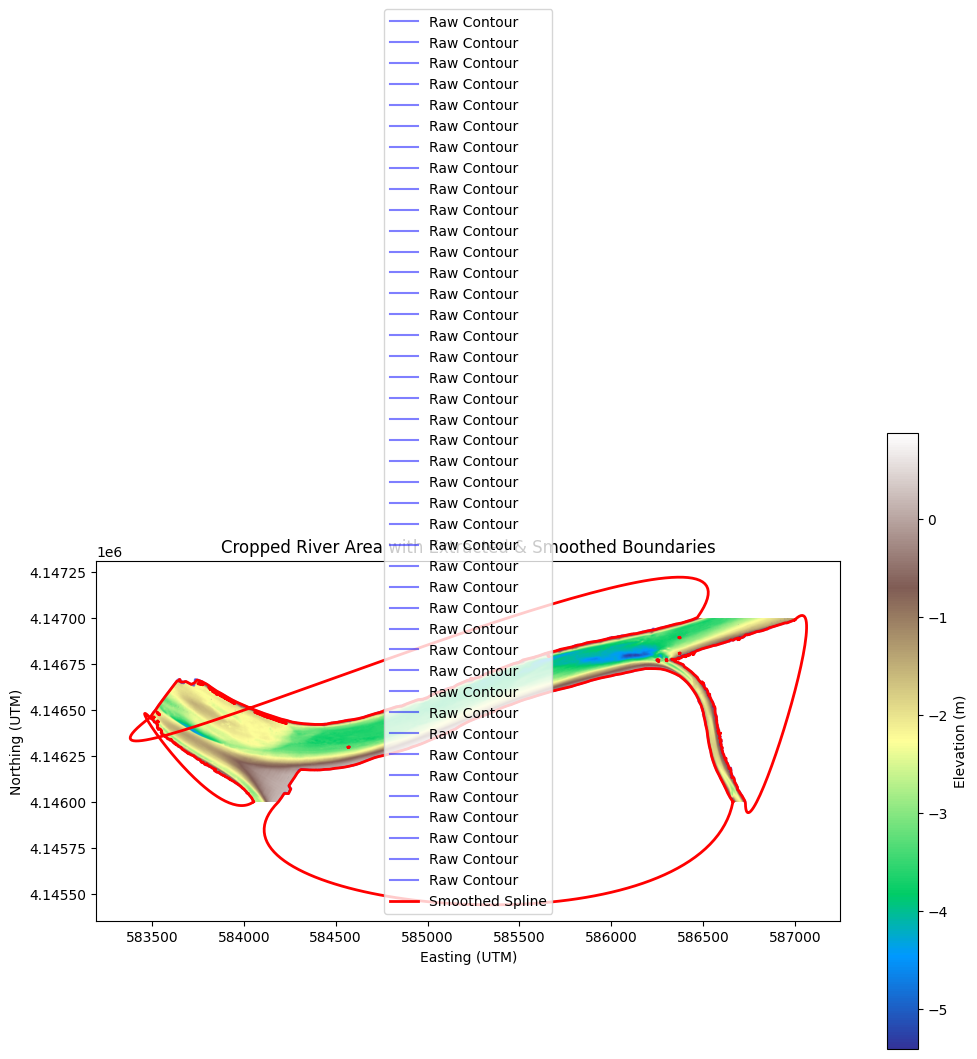

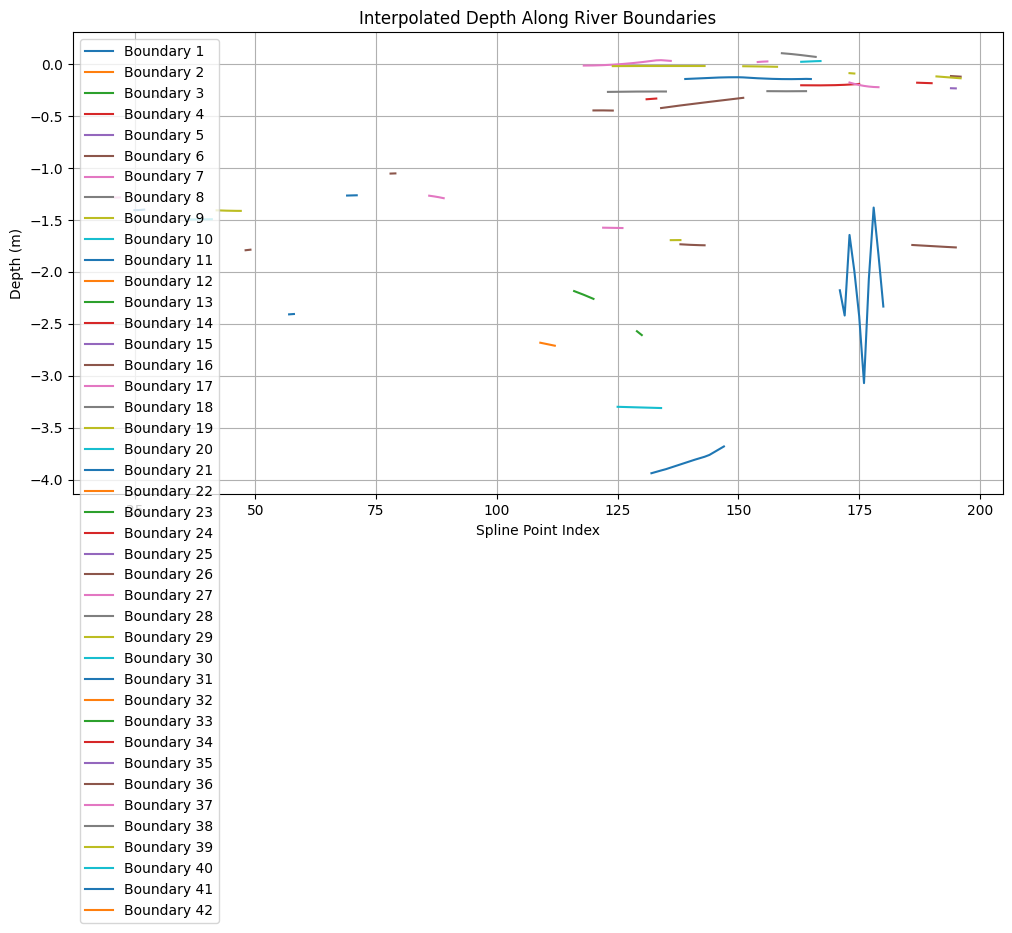

In [36]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.measure import find_contours
from scipy.interpolate import splprep, splev, RegularGridInterpolator

# --- Step 1: Load and Crop the Bathymetric Data ---
asc_file = "/content/Apr19_bathy_NAVD88.asc"

with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Define cropping bounds
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    # Get indices for cropping
    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    x_start, x_end = x_indices.min(), x_indices.max() + 1
    y_start, y_end = y_indices.min(), y_indices.max() + 1
    cropped_array = array[y_start:y_end, x_start:x_end]
    cropped_x = x_coords[x_start:x_end]
    cropped_y = y_coords[y_start:y_end]

# --- Step 2: Extract All Significant Contours from the River Mask ---
# Valid depth data (non-NaN) assumed to be river.
river_mask = ~np.isnan(cropped_array)
contours = find_contours(river_mask.astype(float), 0.5)
if not contours:
    raise ValueError("No river contours found!")

# Filter out very short contours (noise)
filtered_contours = [c for c in contours if len(c) > 20]

# For each contour, convert image coordinates (row, col) to UTM coordinates.
all_boundaries = []  # Each element will be an array of shape (N,2): [x, y]
for contour in filtered_contours:
    # contour: rows, cols relative to cropped_array
    contour_rows = contour[:, 0]
    contour_cols = contour[:, 1]
    world_coords = np.array([transform * (col + x_start, row + y_start)
                               for row, col in zip(contour_rows, contour_cols)])
    all_boundaries.append(world_coords)

# --- Step 3: Fit a Smoothing Spline to Each Boundary ---
# We store splines as dictionaries with keys: 'spline_x', 'spline_y'
splines = []
for boundary in all_boundaries:
    boundary_x = boundary[:, 0]
    boundary_y = boundary[:, 1]
    # Check if contour is closed; if not, force closure.
    if not (np.isclose(boundary_x[0], boundary_x[-1]) and np.isclose(boundary_y[0], boundary_y[-1])):
        boundary_x = np.append(boundary_x, boundary_x[0])
        boundary_y = np.append(boundary_y, boundary_y[0])
    # Fit a periodic spline if closed (per=True); adjust smoothing as needed.
    try:
        tck, _ = splprep([boundary_x, boundary_y], s=5, per=True)
    except Exception as e:
        tck, _ = splprep([boundary_x, boundary_y], s=5)
    u_fine = np.linspace(0, 1, 200)
    spline_x, spline_y = splev(u_fine, tck)
    splines.append({'spline_x': spline_x, 'spline_y': spline_y})

# --- Step 4: Interpolate Depth Data Along Each Continuous Boundary ---
# Create an interpolator on the cropped bathymetry.
# RegularGridInterpolator requires the grid axes to be in ascending order.
cropped_y_sorted = cropped_y[::-1]
cropped_array_sorted = cropped_array[::-1, :]
interp_func = RegularGridInterpolator((cropped_y_sorted, cropped_x),
                                      cropped_array_sorted,
                                      bounds_error=False,
                                      fill_value=np.nan)

# For each spline, interpolate the bathymetric depth.
for spline in splines:
    # Note: interp_func expects (y, x) pairs.
    points = np.column_stack((spline['spline_y'], spline['spline_x']))
    spline['depth'] = interp_func(points)

# --- Step 5: Visualization ---

# 5a. Plot the full DEM with the cropping rectangle.
plt.figure(figsize=(12, 8))
plt.imshow(array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label="Elevation (m)")
plt.gca().add_patch(Rectangle((x_range[0], y_range[0]),
                              x_range[1]-x_range[0],
                              y_range[1]-y_range[0],
                              linewidth=2, edgecolor='red', facecolor='none'))
plt.title("Bathymetric DEM with Cropping Range")
plt.xlabel("Easting (UTM)")
plt.ylabel("Northing (UTM)")
plt.show()

# 5b. Plot the cropped area with all extracted and smoothed boundaries.
plt.figure(figsize=(12, 8))
plt.imshow(cropped_array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[cropped_x[0], cropped_x[-1], cropped_y[-1], cropped_y[0]])
plt.colorbar(label="Elevation (m)")

# Plot raw contours in blue and smoothed splines in red.
for boundary in all_boundaries:
    plt.plot(boundary[:,0], boundary[:,1], 'b-', alpha=0.5, label="Raw Contour")
for idx, spline in enumerate(splines):
    plt.plot(spline['spline_x'], spline['spline_y'], 'r-', linewidth=2,
             label="Smoothed Spline" if idx==0 else None)
plt.title("Cropped River Area with Extracted & Smoothed Boundaries")
plt.xlabel("Easting (UTM)")
plt.ylabel("Northing (UTM)")
plt.legend()
plt.show()

# 5c. Plot the interpolated depth along each continuous boundary.
plt.figure(figsize=(12, 6))
for idx, spline in enumerate(splines):
    plt.plot(spline['depth'], label=f"Boundary {idx+1}")
plt.title("Interpolated Depth Along River Boundaries")
plt.xlabel("Spline Point Index")
plt.ylabel("Depth (m)")
plt.legend()
plt.grid(True)
plt.show()

# --- Final Notes ---
# Each entry in 'splines' now holds the continuous (spline_x, spline_y) boundary and
# its corresponding 'depth'. You can use these to impose continuous Neumann boundary
# conditions (e.g., computing normal derivatives from the spline) in your simulation.


KeyboardInterrupt: 

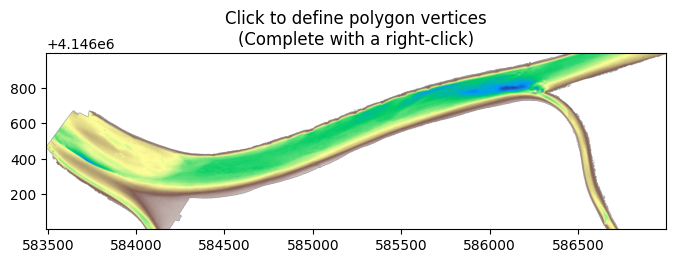

In [37]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# --- Step 1: Load and Crop the Bathymetric Data ---
asc_file = "/content/Apr19_bathy_NAVD88.asc"

with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Define cropping bounds
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    x_start, x_end = x_indices.min(), x_indices.max() + 1
    y_start, y_end = y_indices.min(), y_indices.max() + 1
    cropped_array = array[y_start:y_end, x_start:x_end]
    cropped_x = x_coords[x_start:x_end]
    cropped_y = y_coords[y_start:y_end]

# --- Step 2: Manually Sketch the Simulation Domain ---
# Display the cropped DEM and let you click to define a polygon.
plt.figure(figsize=(8, 8))
plt.imshow(cropped_array, cmap="terrain", interpolation="bilinear",
           extent=[cropped_x[0], cropped_x[-1], cropped_y[-1], cropped_y[0]],
           origin="upper")
plt.title("Click to define polygon vertices\n(Complete with a right-click)")
# Use plt.ginput to capture an arbitrary number of clicks
polygon_points = plt.ginput(n=-1, timeout=0)
plt.close()

# Convert list to a NumPy array and close the polygon if needed.
polygon_points = np.array(polygon_points)
if not np.allclose(polygon_points[0], polygon_points[-1]):
    polygon_points = np.vstack([polygon_points, polygon_points[0]])

# --- Step 3: Interpolate Depth Along the Polygon Boundary ---
# Build an interpolator on the cropped DEM.
# Note: RegularGridInterpolator expects ascending grid values.
cropped_y_sorted = cropped_y[::-1]
cropped_array_sorted = cropped_array[::-1, :]
interp_func = RegularGridInterpolator((cropped_y_sorted, cropped_x),
                                      cropped_array_sorted,
                                      bounds_error=False,
                                      fill_value=np.nan)

# The polygon is in world coordinates (x,y); the interpolator expects (y,x).
points_for_interp = np.column_stack((polygon_points[:, 1], polygon_points[:, 0]))
depth_profile = interp_func(points_for_interp)

# --- Step 4: Visualize and Save the Results ---
# Plot the cropped DEM with the manually defined polygon.
plt.figure(figsize=(8, 8))
plt.imshow(cropped_array, cmap="terrain", interpolation="bilinear",
           extent=[cropped_x[0], cropped_x[-1], cropped_y[-1], cropped_y[0]],
           origin="upper")
plt.plot(polygon_points[:, 0], polygon_points[:, 1], 'r-', linewidth=2,
         label="Polygon Boundary")
plt.title("Selected Simulation Domain")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend()
plt.show()

# Plot the depth profile along the polygon boundary.
plt.figure(figsize=(10, 4))
plt.plot(depth_profile, 'ko-', markersize=4)
plt.title("Interpolated Depth Profile along Polygon Boundary")
plt.xlabel("Vertex Index")
plt.ylabel("Depth (m)")
plt.grid(True)
plt.show()

# Save coordinates and depth profile for future use.
simulation_domain = {
    'boundary_coords': polygon_points,  # Each row is [x, y]
    'depth_profile': depth_profile
}
print("Simulation domain saved with {} vertices.".format(len(polygon_points)))


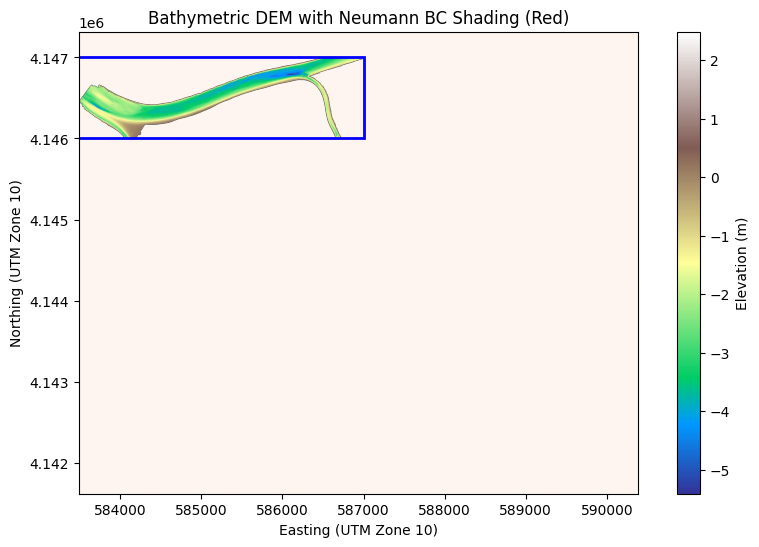

In [39]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    # Get spatial extent
    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])
    X, Y = np.meshgrid(x_coords, y_coords)

    # Define bounding box (river region candidate)
    x_range = (583000, 587000)
    y_range = (4146000, 4147000)

    # Valid river points: inside bounding box AND non-NaN
    valid_mask = ((X >= x_range[0]) & (X <= x_range[1]) &
                  (Y >= y_range[0]) & (Y <= y_range[1]) &
                  (~np.isnan(array)))
    # Neumann BCs applied on all other points
    neumann_mask = ~valid_mask

# Plot DEM with Neumann BC overlay
plt.figure(figsize=(10, 6))
plt.imshow(array, cmap="terrain", interpolation="bilinear", origin="upper",
           extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label="Elevation (m)")

# Create an overlay: value 1 for Neumann points, NaN elsewhere so they appear in red
neumann_overlay = np.where(neumann_mask, 1, np.nan)
plt.imshow(neumann_overlay, cmap="Reds", alpha=1, origin="upper",
           extent=[x_min, x_max, y_min, y_max])

# Draw the bounding box (in blue) for visual reference
rect = Rectangle((x_range[0], y_range[0]),
                 x_range[1] - x_range[0],
                 y_range[1] - y_range[0],
                 linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)

plt.title("Bathymetric DEM with Neumann BC Shading (Red)")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.show()